*You are provided with historical sales data for 45 Walmart stores located in different regions.*
*Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.*

Data Description https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data


In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
root = Path('~/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting').expanduser()

list(root.glob('*.csv'))

[PosixPath('/homes/anvar/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting/features.csv'),
 PosixPath('/homes/anvar/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting/stores.csv'),
 PosixPath('/homes/anvar/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv'),
 PosixPath('/homes/anvar/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting/test.csv'),
 PosixPath('/homes/anvar/gitrepos/ds-for-business/2022/seminar-7/walmart-recruiting-store-sales-forecasting/train.csv')]

In [3]:
train = pd.read_csv(root / 'train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 45 unique Stores, with 81 unique Departments

In [4]:
len(train.Store.unique())

45

In [5]:
len(train.Dept.unique())

81

## Check total weekly sales across all departments

In [6]:
train_stores = train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

In [7]:
train_stores

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68
...,...,...,...
6430,45,2012-09-28,713173.95
6431,45,2012-10-05,733455.07
6432,45,2012-10-12,734464.36
6433,45,2012-10-19,718125.53


In [8]:
train_stores.Date = pd.to_datetime(train_stores.Date)
train_stores['year'] = pd.DatetimeIndex(train_stores.Date).year
train_stores['month'] = pd.DatetimeIndex(train_stores.Date).month
train_stores.index = train_stores.Date

## Store 1

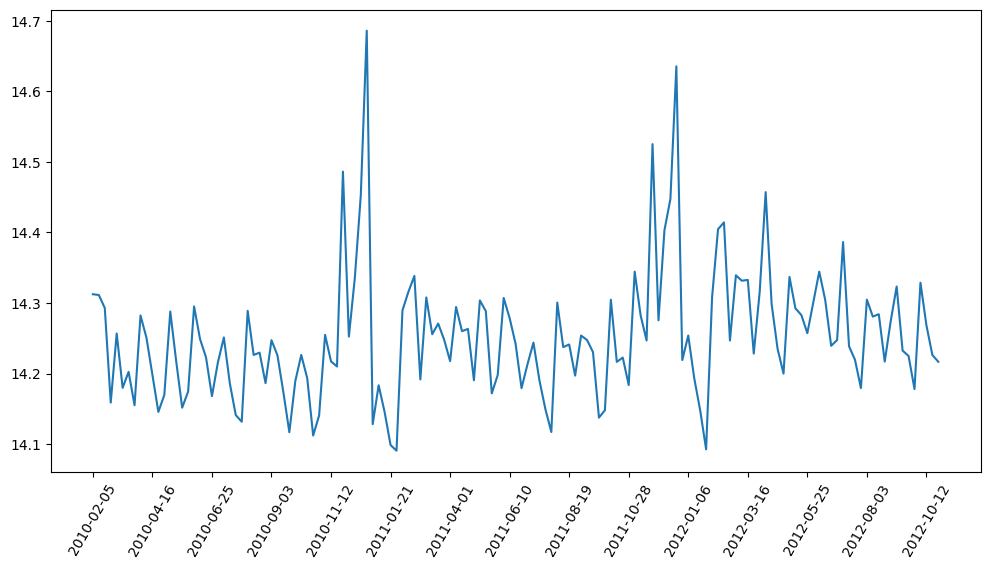

In [9]:
x = train_stores.query('Store==1')

plt.figure(figsize=(12,6))
plt.plot(x.Date,
        np.log(x.Weekly_Sales));
plt.xticks(ticks=x.Date[::10], rotation=60);

## What are the monthly sales accross all stores?

In [10]:
x.groupby([x.year, x.month])['Weekly_Sales'].sum()

year  month
2010  2        6307344.10
      3        5871293.98
      4        7422801.92
      5        5929938.64
      6        6084081.46
      7        7244483.04
      8        6075952.95
      9        5829793.92
      10       7150641.75
      11       6485547.06
      12       8876953.18
2011  1        5480050.97
      2        6399887.57
      3        6307375.48
      4        7689123.60
      5        6128431.80
      6        6194971.74
      7        7227654.31
      8        6144985.73
      9        7379542.34
      10       6072327.75
      11       6864972.83
      12       9032594.71
2012  1        5723690.52
      2        6798074.91
      3        8201997.40
      4        6511214.82
      5        6446962.46
      6        8020582.84
      7        6233946.67
      8        7897619.59
      9        6122381.52
      10       6245587.29
Name: Weekly_Sales, dtype: float64

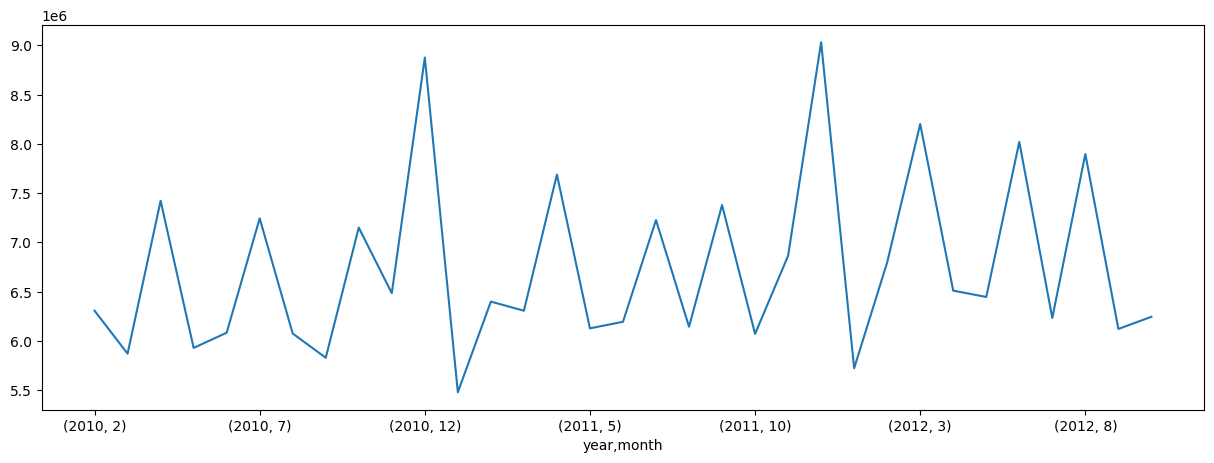

In [11]:
plt.figure(figsize=(15,5))
x.groupby([x.year, x.month])['Weekly_Sales'].sum().plot();

## Is picture similar in another Store `10`?

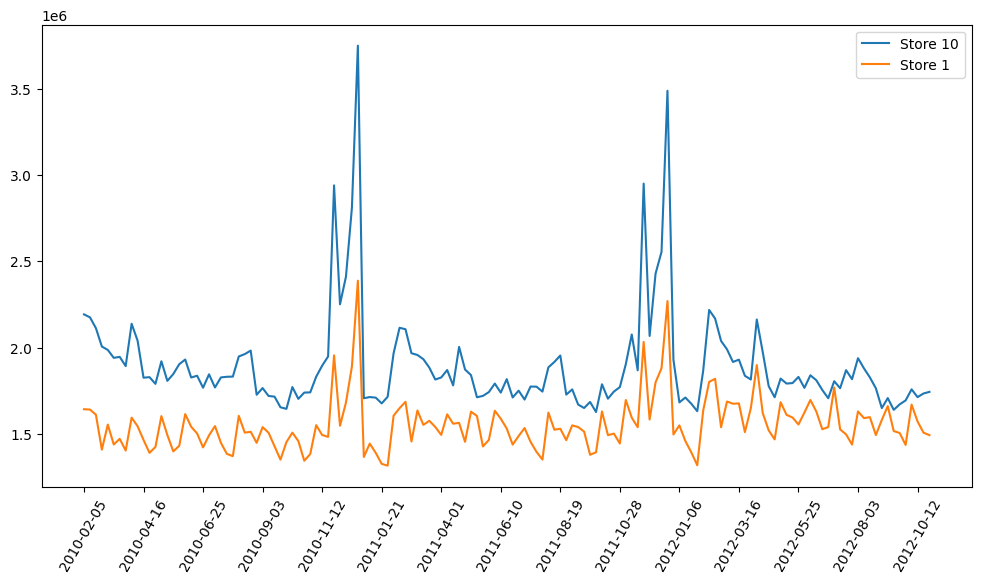

In [12]:
x = train_stores.query('Store==1')
x2 = train_stores.query('Store==10')

plt.figure(figsize=(12,6))
plt.plot(x2.Date, x2.Weekly_Sales, label=f'Store 10');
plt.plot(x.Date, x.Weekly_Sales, label='Store 1');

plt.legend()
plt.xticks(ticks=x2.Date[::10], rotation=60);

# Predict Sales for a single store (sum over all Departments)

Train a simple model. Features are lags: What was the value of TS x timesteps ago?

In [13]:
def generate_features(x, start_lag=8, end_lag=48, test=False):
        
    X = pd.DataFrame(index=x.index)
    for i in range(start_lag, end_lag):
        X['lag_{}'.format(i)] = x['Weekly_Sales'].shift(i)

    return X.dropna()

In [14]:
lag_features = generate_features(x, start_lag=4, end_lag=8)
x_with_lags = pd.merge(x, lag_features, how='left', left_index=True, right_index=True)

In [15]:
x.head()

,Store,Date,Weekly_Sales,year,month
Date,,,,,
2010-02-05,1,2010-02-05,1643690.90,2010,2
2010-02-12,1,2010-02-12,1641957.44,2010,2
2010-02-19,1,2010-02-19,1611968.17,2010,2
2010-02-26,1,2010-02-26,1409727.59,2010,2
2010-03-05,1,2010-03-05,1554806.68,2010,3


In [16]:
x_with_lags.head(10)

,Store,Date,Weekly_Sales,year,month,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,
2010-02-05,1,2010-02-05,1643690.90,2010,2,NaN,NaN,NaN,NaN
2010-02-12,1,2010-02-12,1641957.44,2010,2,NaN,NaN,NaN,NaN
2010-02-19,1,2010-02-19,1611968.17,2010,2,NaN,NaN,NaN,NaN
2010-02-26,1,2010-02-26,1409727.59,2010,2,NaN,NaN,NaN,NaN
2010-03-05,1,2010-03-05,1554806.68,2010,3,NaN,NaN,NaN,NaN
2010-03-12,1,2010-03-12,1439541.59,2010,3,NaN,NaN,NaN,NaN
2010-03-19,1,2010-03-19,1472515.79,2010,3,NaN,NaN,NaN,NaN
2010-03-26,1,2010-03-26,1404429.92,2010,3,1409727.59,1611968.17,1641957.44,1643690.90
2010-04-02,1,2010-04-02,1594968.28,2010,4,1554806.68,1409727.59,1611968.17,1641957.44


In [17]:
x_with_lags = x_with_lags.dropna()

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5)
model.fit(x_with_lags.drop(['Date', 'Weekly_Sales'], axis=1), x_with_lags['Weekly_Sales'])
y_pred = model.predict(x_with_lags.drop(['Date', 'Weekly_Sales'], axis=1))

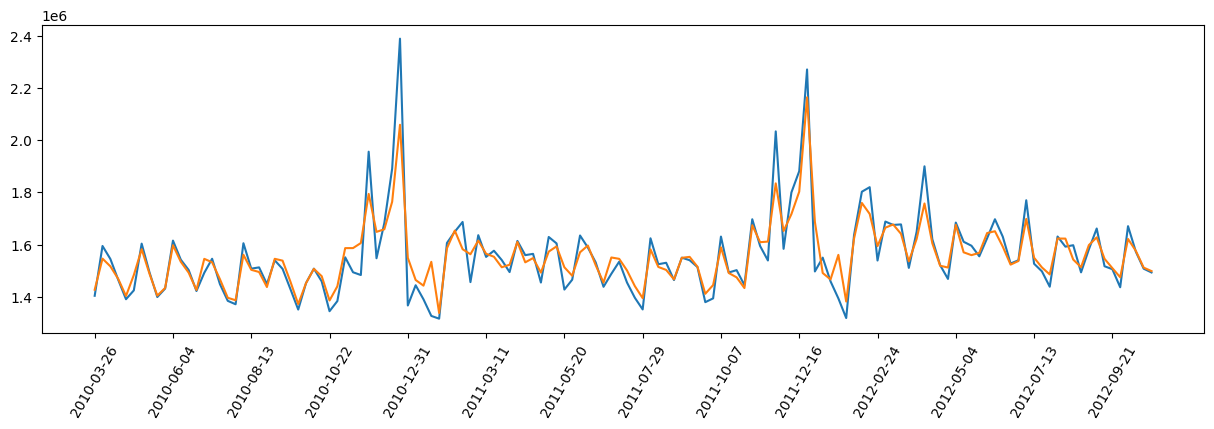

In [20]:
plt.figure(figsize=(15,4))
plt.plot(x_with_lags.index, x_with_lags['Weekly_Sales'])
plt.plot(x_with_lags.index, y_pred)
plt.xticks(ticks=x_with_lags.index[::10], rotation=60);

# Split data on train and test

In [21]:
x_train = x.truncate(after='2012-01-01')
x_test= x.truncate(before='2012-01-01')

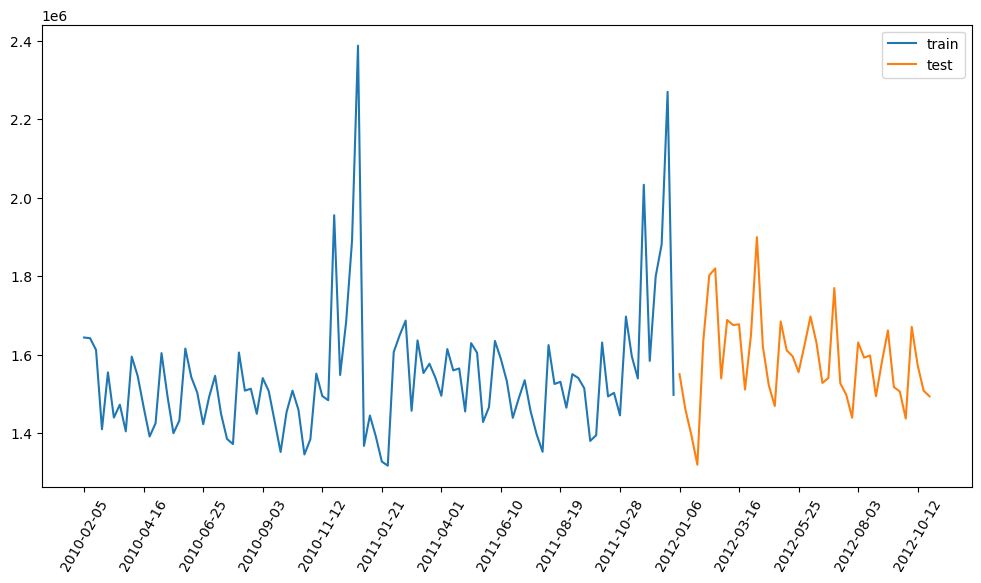

In [22]:
plt.figure(figsize=(12,6))
plt.plot(x_train.Date, x_train.Weekly_Sales, label=f'train');
plt.plot(x_test.Date, x_test.Weekly_Sales, label='test');

plt.legend()
plt.xticks(ticks=x.Date[::10], rotation=60);

# Baseline: predict sales by sales year ago

In [23]:
from sklearn.metrics import mean_absolute_error

In [24]:
index_test = x_test.index
X = pd.DataFrame(index=x.index)
X['sales'] = x['Weekly_Sales'].shift(52)
X['Weekly_Sales'] = x['Weekly_Sales']
X.dropna(inplace=True)
X = X.loc[index_test]

mean_absolute_error(X['Weekly_Sales'],X['sales'])

77801.41604651163

In [25]:
X['Weekly_Sales'].mean()

1586094.3725581397

In [26]:
# ~5% error
mean_absolute_error(X['Weekly_Sales'],X['sales']) / X['Weekly_Sales'].mean() * 100

4.905219852777691

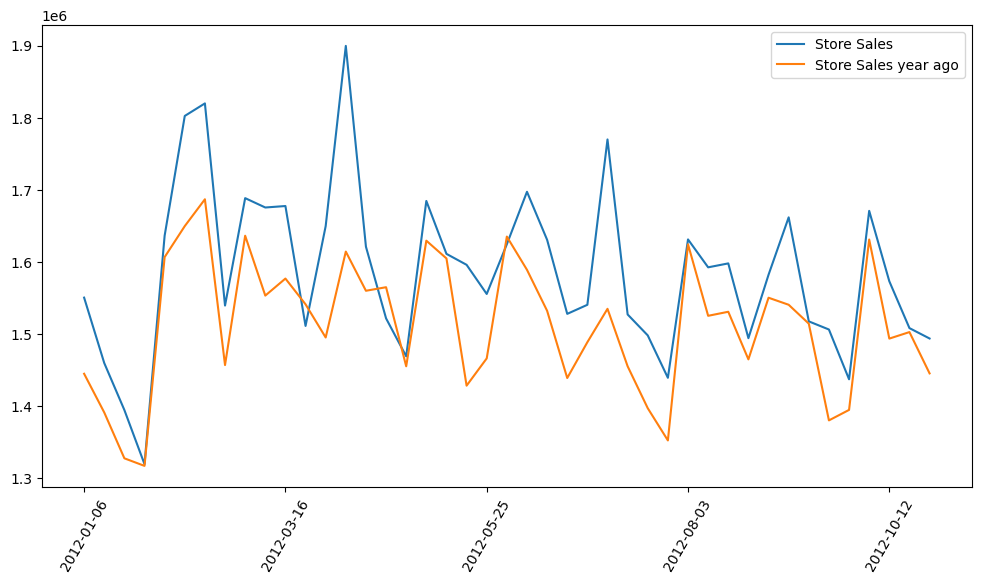

In [27]:
plt.figure(figsize=(12,6))
plt.plot(X.index, X.Weekly_Sales, label=f'Store Sales');
plt.plot(X.index, X.sales, label='Store Sales year ago');
plt.legend()
plt.xticks(ticks=X.index[::10], rotation=60);

# Can we do better?

RF on lag features

In [28]:
def generate_features(x, x_test=None, start_lag=8, end_lag=48):
    
    if x_test is not None:
        index_test = x_test.index
        x = pd.concat([x, x_test])
        
    X = pd.DataFrame(index=x.index)
    for i in range(start_lag, end_lag):
        X['lag_{}'.format(i)] = x['Weekly_Sales'].shift(i)
    
    if x_test is not None:
        return X.loc[index_test]
    return X.dropna()

In [29]:
x = train_stores.query('Store==1')
lag_features = generate_features(x, start_lag=4, end_lag=8)
x_with_lags = pd.merge(x, lag_features, how='left', left_index=True, right_index=True)

X_train = x_with_lags.truncate(after='2012-01-01').dropna()
X_test= x_with_lags.truncate(before='2012-01-01')

In [30]:
X_test.head(3)

,Store,Date,Weekly_Sales,year,month,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,
2012-01-06,1,2012-01-06,1550369.92,2012,1,1799682.38,1584083.95,2033320.66,1539483.70
2012-01-13,1,2012-01-13,1459601.17,2012,1,1881176.67,1799682.38,1584083.95,2033320.66
2012-01-20,1,2012-01-20,1394393.84,2012,1,2270188.99,1881176.67,1799682.38,1584083.95


In [31]:
random_state=19
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5, random_state=random_state)
model.fit(X_train.drop(['Store','Date','Weekly_Sales'], axis=1), X_train['Weekly_Sales'])

y_pred_train = model.predict(X_train.drop(['Store','Date','Weekly_Sales'], axis=1))
y_pred_test = model.predict(X_test.drop(['Store','Date','Weekly_Sales'], axis=1))

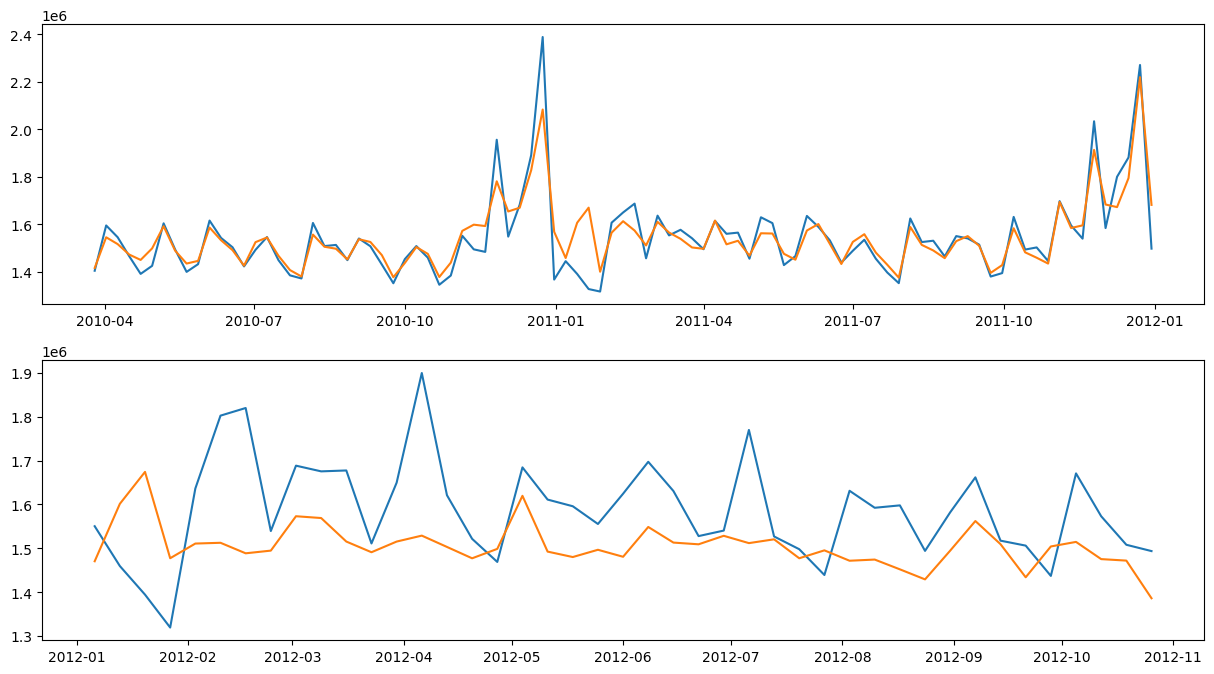

In [32]:
fig, axs = plt.subplots(2,1,figsize=(15,8))


axs[0].plot(X_train.index, X_train['Weekly_Sales'])
axs[0].plot(X_train.index, y_pred_train)

axs[1].plot(X_test.index, X_test['Weekly_Sales'])
axs[1].plot(X_test.index, y_pred_test);

In [33]:
mean_absolute_error(X_test['Weekly_Sales'], y_pred_test)

114235.95249470284

In [34]:
X_test['Weekly_Sales'].mean()

1586094.3725581397

# Add more features: rolling mean, diff

In [35]:
def generate_features(x, x_test=None, start_lag=8, end_lag=48):
    
    if x_test is not None:
        index_test = x_test.index
        x = pd.concat([x, x_test])
        
    X = pd.DataFrame(index=x.index)
    # Lags
    for i in range(start_lag, end_lag, 2):
        X[f'lag_{i}'] = x['Weekly_Sales'].shift(i)
        
    # Diff
    for i in range(start_lag, end_lag, 12):
        X[f'diff_{i}_1'] = x['Weekly_Sales'].shift(i).diff(1)
    
    # Mean
    for i in range(start_lag, end_lag, 12):
        X[f'mean_{i}_2'] = x['Weekly_Sales'].shift(i).rolling(window=5).mean()
    
    if x_test is not None:
        return X.loc[index_test]
    return X.dropna()

In [36]:
x = train_stores.query('Store==1')
lag_features = generate_features(x, start_lag=8, end_lag=12)
x_with_lags = pd.merge(x, lag_features, how='left', left_index=True, right_index=True)

X_train = x_with_lags.truncate(after='2012-01-01').dropna()
X_test= x_with_lags.truncate(before='2012-01-01')

In [37]:
X_test.head(3)

,Store,Date,Weekly_Sales,year,month,lag_8,lag_10,diff_8_1,mean_8_2
Date,,,,,,,,,
2012-01-06,1,2012-01-06,1550369.92,2012,1,1594938.89,1445249.09,-102290.69,1546701.254
2012-01-13,1,2012-01-13,1459601.17,2012,1,1539483.70,1697229.58,-55455.19,1555892.808
2012-01-20,1,2012-01-20,1394393.84,2012,1,2033320.66,1594938.89,493836.96,1662044.384


In [38]:
random_state=19
model = RandomForestRegressor(n_estimators=30, max_depth=20, min_samples_split=5, random_state=random_state)
model.fit(X_train.drop(['Store','Date','Weekly_Sales'], axis=1), X_train['Weekly_Sales'])

y_pred_train = model.predict(X_train.drop(['Store','Date','Weekly_Sales'], axis=1))
y_pred_test = model.predict(X_test.drop(['Store','Date','Weekly_Sales'], axis=1))

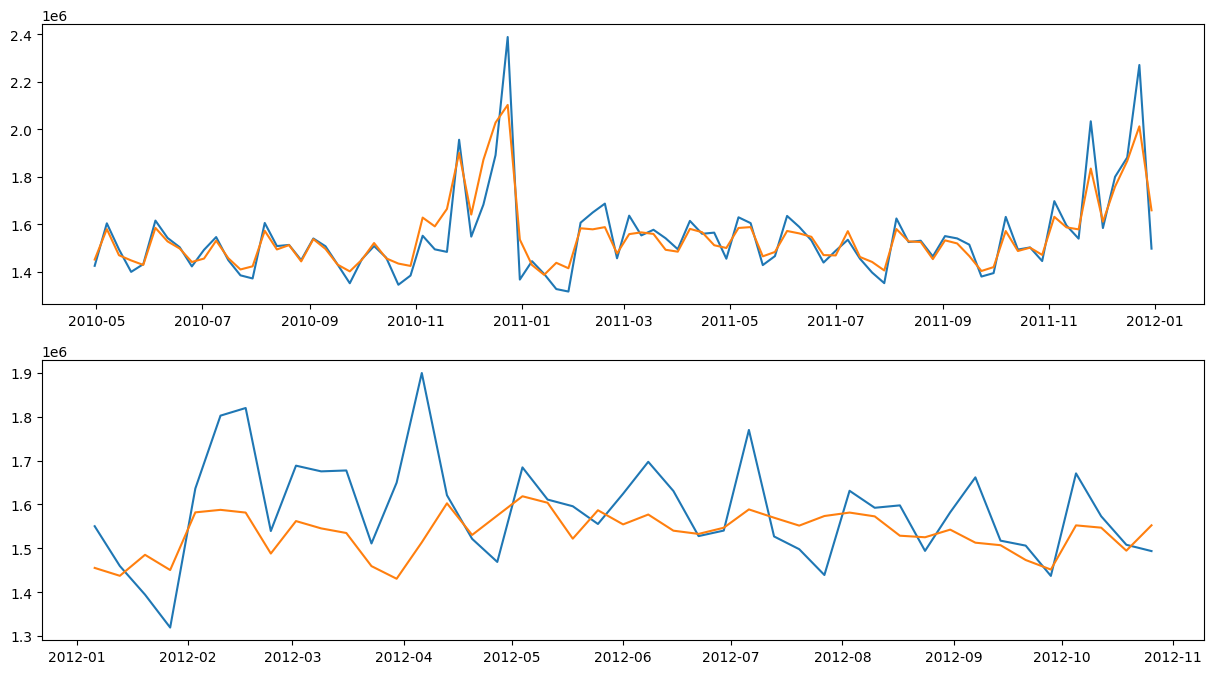

In [39]:
fig, axs = plt.subplots(2,1,figsize=(15,8))


axs[0].plot(X_train.index, X_train['Weekly_Sales'])
axs[0].plot(X_train.index, y_pred_train)

axs[1].plot(X_test.index, X_test['Weekly_Sales'])
axs[1].plot(X_test.index, y_pred_test);

In [40]:
mean_absolute_error(X_test['Weekly_Sales'], y_pred_test)

83765.76038425928

In [41]:
X_test['Weekly_Sales'].mean()

1586094.3725581397

# Now let's build a model for `ALL` Stores and Departments 

In [42]:
train = pd.read_csv(root / 'train.csv')
stores = pd.read_csv(root / 'stores.csv')
features = pd.read_csv(root / 'features.csv')

In [43]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [44]:
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


# Join all data

In [45]:
data = pd.merge(train, stores, on='Store')
data = pd.merge(data, features, on=['Store', 'Date'])\
               .drop('IsHoliday_y', axis=1)\
               .rename(columns={'IsHoliday_x': 'Is_Holiday'})

In [46]:
def generate_features(x, start_lag=8, end_lag=48):
    # Recall that lags are in weeks, so 8 weeks is ~2 months
   
    X = pd.DataFrame(index=x.index)
    # Lags
    for i in range(start_lag, end_lag, 2):
        X[f'lag_{i}'] = x['Weekly_Sales'].shift(i)
        
    # Diff
    for i in range(start_lag, end_lag, 12):
        X[f'diff_{i}_1'] = x['Weekly_Sales'].shift(i).diff(1)
    
    # Mean
    for i in range(start_lag, end_lag, 12):
        X[f'mean_{i}_2'] = x['Weekly_Sales'].shift(i).rolling(window=5).mean()
    
    X['Date'] = x.Date

    return X.dropna()

In [47]:
lag_features = data.groupby(['Store', 'Dept']).apply(generate_features)

In [48]:
data = pd.merge(data, lag_features.reset_index(), how='left', on=['Store', 'Dept', 'Date'])

In [49]:
data.shape

(421570, 45)

In [50]:
data.head()

,Store,Dept,Date,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,lag_44,lag_46,diff_8_1,diff_20_1,diff_32_1,diff_44_1,mean_8_2,mean_20_2,mean_32_2,mean_44_2
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Convert `Date` column

In [51]:
data.index = pd.to_datetime(data.Date)
data.Date = pd.to_datetime(data.Date)

data['week'] = data.Date.dt.day // 7
data['month'] = data.Date.dt.month

data = data.sort_index()
data = data.drop('Date', axis=1)

# Split into `train` and `test`

In [52]:
x_train = data.truncate(after='2012-05-01')
x_test= data.truncate(before='2012-05-01')

print(x_train.shape, x_test.shape)

(344667, 46) (76903, 46)


In [53]:
x_train.head(3)

,Store,Dept,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,diff_8_1,diff_20_1,diff_32_1,diff_44_1,mean_8_2,mean_20_2,mean_32_2,mean_44_2,week,month
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2010-02-05,35,3,14612.19,False,B,103681,27.19,2.784,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2010-02-05,35,4,26323.15,False,B,103681,27.19,2.784,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2


In [54]:
x_train.tail(3)

,Store,Dept,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,diff_8_1,diff_20_1,diff_32_1,diff_44_1,mean_8_2,mean_20_2,mean_32_2,mean_44_2,week,month
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-27,32,90,58987.21,False,A,203007,61.76,3.927,4162.67,126.71,...,2724.40,8430.29,-1718.28,789.91,65873.146,69594.976,64327.952,59898.696,3,4
2012-04-27,2,1,22414.38,False,A,202307,67.20,3.814,3076.68,NaN,...,-57.52,13680.89,1424.22,-1004.84,39724.798,29243.290,22627.242,21784.192,3,4
2012-04-27,32,97,15871.47,False,A,203007,61.76,3.927,4162.67,126.71,...,-346.83,3256.09,-1035.32,19.43,16820.328,17028.324,18256.342,18174.276,3,4


In [55]:
x_test.head(3)

,Store,Dept,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,diff_8_1,diff_20_1,diff_32_1,diff_44_1,mean_8_2,mean_20_2,mean_32_2,mean_44_2,week,month
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-04,40,59,141.04,False,A,155083,44.47,3.991,11685.51,NaN,...,19.07,544.36,14.71,-37.16,149.038,576.234,173.798,133.192,0,5
2012-05-04,30,21,1090.69,False,C,42988,77.53,3.749,1136.36,NaN,...,105.09,-197.45,-232.24,-209.59,1205.794,1236.762,1055.260,1846.850,0,5
2012-05-04,30,25,79.08,False,C,42988,77.53,3.749,1136.36,NaN,...,0.16,6.00,-5.25,-1.60,23.622,17.162,17.360,66.230,0,5


## Ideas for other features

You could compute different aggregates:

1. Weekly_Sales over Stores with the same Type, at the same Month/Week
2. Average/Min/Max Temperature for each week
3. Adjust for Fuel_Price: for a given Store what was Weekly_Sales of other Stores with about the same Fuel_Price?
4. Correct on Unemployment: for each Store and week Flag if Unemployment goes down or up since some time stemp
5. Normalize Weekly_Sales on Size of a Store
6. Average Fuel_Price over the last week/month/season
7. Is this week a Holiday or not
8. ...

# Train `catboost` regressor

In [56]:
# !pip install catboost

In [57]:
from catboost import CatBoostRegressor

In [58]:
cat_features = ['Store','Dept', 'Is_Holiday','Type','Size','week', 'month']

reg = CatBoostRegressor()
reg.fit(x_train.drop('Weekly_Sales', axis=1), x_train['Weekly_Sales'], cat_features=cat_features)

Learning rate set to 0.10306
0:	learn: 21397.6522394	total: 181ms	remaining: 3m 1s
1:	learn: 19977.6823996	total: 279ms	remaining: 2m 19s
2:	learn: 18678.1831162	total: 363ms	remaining: 2m
3:	learn: 17559.0136147	total: 469ms	remaining: 1m 56s
4:	learn: 16565.1773400	total: 560ms	remaining: 1m 51s
5:	learn: 15680.5659430	total: 645ms	remaining: 1m 46s
6:	learn: 14879.6889404	total: 797ms	remaining: 1m 53s
7:	learn: 14217.3962160	total: 868ms	remaining: 1m 47s
8:	learn: 13632.7972909	total: 953ms	remaining: 1m 44s
9:	learn: 13101.0232090	total: 1.04s	remaining: 1m 42s
10:	learn: 12648.4140365	total: 1.12s	remaining: 1m 40s
11:	learn: 12227.4818871	total: 1.22s	remaining: 1m 40s
12:	learn: 11866.8731043	total: 1.31s	remaining: 1m 39s
13:	learn: 11547.0516515	total: 1.43s	remaining: 1m 40s
14:	learn: 11269.1019760	total: 1.52s	remaining: 1m 40s
15:	learn: 11027.1540830	total: 1.6s	remaining: 1m 38s
16:	learn: 10815.4653225	total: 1.69s	remaining: 1m 37s
17:	learn: 10628.7273291	total: 1.7

148:	learn: 7135.9178193	total: 14.5s	remaining: 1m 22s
149:	learn: 7128.1510684	total: 14.6s	remaining: 1m 22s
150:	learn: 7118.3212976	total: 14.7s	remaining: 1m 22s
151:	learn: 7114.8658762	total: 14.8s	remaining: 1m 22s
152:	learn: 7108.6460874	total: 14.9s	remaining: 1m 22s
153:	learn: 7102.0300793	total: 15s	remaining: 1m 22s
154:	learn: 7095.2655461	total: 15.1s	remaining: 1m 22s
155:	learn: 7090.3521966	total: 15.2s	remaining: 1m 22s
156:	learn: 7083.6806741	total: 15.3s	remaining: 1m 22s
157:	learn: 7075.7719372	total: 15.4s	remaining: 1m 21s
158:	learn: 7057.5611992	total: 15.5s	remaining: 1m 21s
159:	learn: 7050.8711541	total: 15.6s	remaining: 1m 21s
160:	learn: 7049.3258504	total: 15.7s	remaining: 1m 21s
161:	learn: 7041.6719524	total: 15.8s	remaining: 1m 21s
162:	learn: 7036.7874159	total: 15.9s	remaining: 1m 21s
163:	learn: 6983.7628328	total: 16s	remaining: 1m 21s
164:	learn: 6966.0711737	total: 16s	remaining: 1m 21s
165:	learn: 6936.7516700	total: 16.1s	remaining: 1m 21

296:	learn: 6123.8354808	total: 29.9s	remaining: 1m 10s
297:	learn: 6121.6609825	total: 30s	remaining: 1m 10s
298:	learn: 6120.0189648	total: 30.1s	remaining: 1m 10s
299:	learn: 6118.3607286	total: 30.2s	remaining: 1m 10s
300:	learn: 6115.8685560	total: 30.3s	remaining: 1m 10s
301:	learn: 6113.1388252	total: 30.4s	remaining: 1m 10s
302:	learn: 6111.9204129	total: 30.5s	remaining: 1m 10s
303:	learn: 6109.8133656	total: 30.6s	remaining: 1m 10s
304:	learn: 6108.4724907	total: 30.7s	remaining: 1m 10s
305:	learn: 6107.2134366	total: 30.8s	remaining: 1m 9s
306:	learn: 6104.4491613	total: 30.9s	remaining: 1m 9s
307:	learn: 6102.6139901	total: 31s	remaining: 1m 9s
308:	learn: 6099.6412474	total: 31.1s	remaining: 1m 9s
309:	learn: 6097.8910371	total: 31.2s	remaining: 1m 9s
310:	learn: 6086.0475358	total: 31.3s	remaining: 1m 9s
311:	learn: 6078.6958437	total: 31.4s	remaining: 1m 9s
312:	learn: 6077.0998948	total: 31.5s	remaining: 1m 9s
313:	learn: 6074.4502722	total: 31.6s	remaining: 1m 8s
314:	

448:	learn: 5636.3133207	total: 45s	remaining: 55.2s
449:	learn: 5631.7332945	total: 45.1s	remaining: 55.1s
450:	learn: 5630.4967077	total: 45.2s	remaining: 55s
451:	learn: 5628.9350796	total: 45.3s	remaining: 54.9s
452:	learn: 5616.2467709	total: 45.4s	remaining: 54.8s
453:	learn: 5604.7534665	total: 45.5s	remaining: 54.7s
454:	learn: 5603.6873354	total: 45.6s	remaining: 54.6s
455:	learn: 5600.1197952	total: 45.7s	remaining: 54.5s
456:	learn: 5598.4463803	total: 45.8s	remaining: 54.4s
457:	learn: 5595.3453883	total: 45.9s	remaining: 54.3s
458:	learn: 5593.3438241	total: 46s	remaining: 54.2s
459:	learn: 5592.4016383	total: 46.1s	remaining: 54.1s
460:	learn: 5590.6718462	total: 46.2s	remaining: 54s
461:	learn: 5588.5526442	total: 46.2s	remaining: 53.9s
462:	learn: 5587.0491686	total: 46.3s	remaining: 53.8s
463:	learn: 5586.0657204	total: 46.4s	remaining: 53.6s
464:	learn: 5584.8608472	total: 46.5s	remaining: 53.5s
465:	learn: 5583.7876976	total: 46.6s	remaining: 53.4s
466:	learn: 5583.0

599:	learn: 5274.4907378	total: 1m	remaining: 40.1s
600:	learn: 5273.0687053	total: 1m	remaining: 40s
601:	learn: 5272.8889896	total: 1m	remaining: 39.9s
602:	learn: 5272.2323043	total: 1m	remaining: 39.8s
603:	learn: 5272.1210293	total: 1m	remaining: 39.7s
604:	learn: 5270.9874846	total: 1m	remaining: 39.6s
605:	learn: 5269.8289640	total: 1m	remaining: 39.5s
606:	learn: 5268.8765417	total: 1m	remaining: 39.4s
607:	learn: 5268.1430434	total: 1m	remaining: 39.3s
608:	learn: 5267.6432550	total: 1m 1s	remaining: 39.2s
609:	learn: 5266.8772168	total: 1m 1s	remaining: 39.1s
610:	learn: 5265.7716655	total: 1m 1s	remaining: 39s
611:	learn: 5264.8610969	total: 1m 1s	remaining: 38.9s
612:	learn: 5264.1592662	total: 1m 1s	remaining: 38.8s
613:	learn: 5263.3326686	total: 1m 1s	remaining: 38.7s
614:	learn: 5262.7301156	total: 1m 1s	remaining: 38.6s
615:	learn: 5261.0406652	total: 1m 1s	remaining: 38.5s
616:	learn: 5259.8755423	total: 1m 1s	remaining: 38.4s
617:	learn: 5258.3418521	total: 1m 2s	rem

749:	learn: 5062.8265752	total: 1m 16s	remaining: 25.4s
750:	learn: 5061.9123561	total: 1m 16s	remaining: 25.3s
751:	learn: 5061.0083425	total: 1m 16s	remaining: 25.2s
752:	learn: 5060.3191855	total: 1m 16s	remaining: 25.1s
753:	learn: 5059.5074046	total: 1m 16s	remaining: 25s
754:	learn: 5049.6992806	total: 1m 16s	remaining: 24.9s
755:	learn: 5049.6551752	total: 1m 16s	remaining: 24.8s
756:	learn: 5048.8374818	total: 1m 16s	remaining: 24.7s
757:	learn: 5048.8049988	total: 1m 17s	remaining: 24.6s
758:	learn: 5040.6713220	total: 1m 17s	remaining: 24.5s
759:	learn: 5039.7446023	total: 1m 17s	remaining: 24.4s
760:	learn: 5039.3063684	total: 1m 17s	remaining: 24.3s
761:	learn: 5038.6634873	total: 1m 17s	remaining: 24.2s
762:	learn: 5038.2935810	total: 1m 17s	remaining: 24.1s
763:	learn: 5037.4640335	total: 1m 17s	remaining: 24s
764:	learn: 5036.9035696	total: 1m 17s	remaining: 23.9s
765:	learn: 5036.3234552	total: 1m 17s	remaining: 23.8s
766:	learn: 5035.2741442	total: 1m 17s	remaining: 23

896:	learn: 4867.5118592	total: 1m 32s	remaining: 10.6s
897:	learn: 4867.4749712	total: 1m 32s	remaining: 10.5s
898:	learn: 4866.8890771	total: 1m 32s	remaining: 10.4s
899:	learn: 4865.2734013	total: 1m 32s	remaining: 10.3s
900:	learn: 4865.1463344	total: 1m 32s	remaining: 10.2s
901:	learn: 4864.3284819	total: 1m 33s	remaining: 10.1s
902:	learn: 4863.6508332	total: 1m 33s	remaining: 10s
903:	learn: 4863.0142643	total: 1m 33s	remaining: 9.9s
904:	learn: 4862.0027284	total: 1m 33s	remaining: 9.79s
905:	learn: 4861.6776699	total: 1m 33s	remaining: 9.7s
906:	learn: 4861.3269574	total: 1m 33s	remaining: 9.59s
907:	learn: 4860.9004484	total: 1m 33s	remaining: 9.49s
908:	learn: 4860.5844816	total: 1m 33s	remaining: 9.38s
909:	learn: 4860.1531641	total: 1m 33s	remaining: 9.28s
910:	learn: 4858.2634031	total: 1m 33s	remaining: 9.18s
911:	learn: 4857.8087010	total: 1m 34s	remaining: 9.07s
912:	learn: 4854.4156275	total: 1m 34s	remaining: 8.97s
913:	learn: 4853.8486541	total: 1m 34s	remaining: 8.

In [59]:
y_pred_test = reg.predict(x_test.drop('Weekly_Sales', axis=1))
y_pred_train = reg.predict(x_train.drop('Weekly_Sales', axis=1))

In [60]:
mean_absolute_error(x_test['Weekly_Sales'], y_pred_test)

2084.12219019344

In [61]:
mean_absolute_error(x_train['Weekly_Sales'], y_pred_train)

2184.6454586544683

In [62]:
y_pred_test

array([  804.79129635,  1195.07290316,   446.4559961 , ...,
        3567.22959139, 34048.33221953,   599.99227704])

In [63]:
x_test

,Store,Dept,Weekly_Sales,Is_Holiday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,diff_8_1,diff_20_1,diff_32_1,diff_44_1,mean_8_2,mean_20_2,mean_32_2,mean_44_2,week,month
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-04,40,59,141.04,False,A,155083,44.47,3.991,11685.51,NaN,...,19.07,544.36,14.71,-37.16,149.038,576.234,173.798,133.192,0,5
2012-05-04,30,21,1090.69,False,C,42988,77.53,3.749,1136.36,NaN,...,105.09,-197.45,-232.24,-209.59,1205.794,1236.762,1055.260,1846.850,0,5
2012-05-04,30,25,79.08,False,C,42988,77.53,3.749,1136.36,NaN,...,0.16,6.00,-5.25,-1.60,23.622,17.162,17.360,66.230,0,5
2012-05-04,30,28,61.00,False,C,42988,77.53,3.749,1136.36,NaN,...,10.50,-51.15,11.92,26.95,83.130,83.698,40.130,56.710,0,5
2012-05-04,25,6,2988.40,False,B,128107,58.76,3.951,7221.10,NaN,...,-412.71,2044.96,-1523.87,438.04,2277.480,7718.574,2221.886,4880.150,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,13,49,7770.71,False,A,219622,46.97,3.755,10192.49,364.57,...,-925.98,873.93,-4608.35,1034.90,11010.884,8476.184,11375.550,7834.908,3,10
2012-10-26,13,50,1486.00,False,A,219622,46.97,3.755,10192.49,364.57,...,-1419.00,804.00,-872.00,-587.00,2529.800,2049.000,2750.400,1820.250,3,10
2012-10-26,13,52,4738.93,False,A,219622,46.97,3.755,10192.49,364.57,...,-430.23,627.81,74.79,395.06,3053.588,4656.950,4641.880,7584.298,3,10


In [64]:
test_dataframe = x_test[['Store', 'Dept', 'Weekly_Sales']]
test_dataframe['Weekly_Sales_predicted'] = y_pred_test
test_dataframe = test_dataframe.reset_index()

/tmp/ipykernel_264437/2720023798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataframe['Weekly_Sales_predicted'] = y_pred_test


# Catboost feature importance

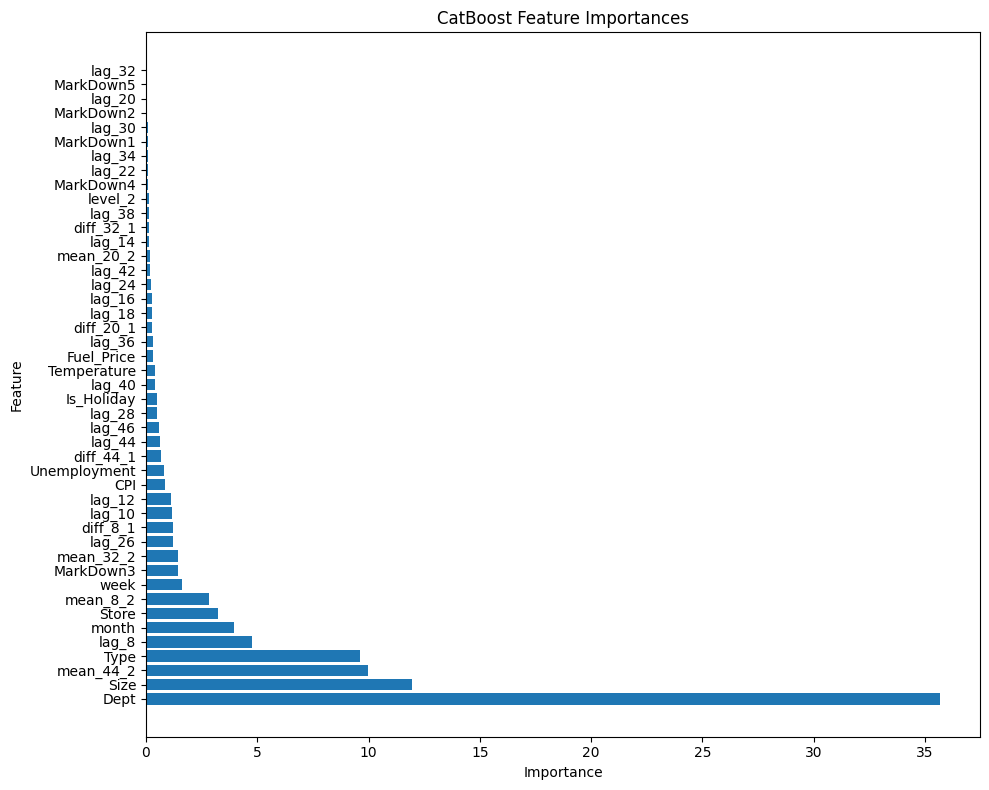

In [65]:
feature_importances = reg.feature_importances_

feature_names = reg.feature_names_
df_feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Step 4: Sort the DataFrame based on the importances
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False)

# Step 5: Plot the feature importances using a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importances')
plt.tight_layout()
plt.show()


# Compare results with our first models

In [66]:
test_dataframe.head()

,Date,Store,Dept,Weekly_Sales,Weekly_Sales_predicted
0,2012-05-04,40,59,141.04,804.791296
1,2012-05-04,30,21,1090.69,1195.072903
2,2012-05-04,30,25,79.08,446.455996
3,2012-05-04,30,28,61.00,102.233860
4,2012-05-04,25,6,2988.40,3909.235714


In [67]:
stores = test_dataframe.groupby(['Store', 'Date'])[['Weekly_Sales', 'Weekly_Sales_predicted']].sum().reset_index()

In [68]:
stores.head()

,Store,Date,Weekly_Sales,Weekly_Sales_predicted
0,1,2012-05-04,1684519.99,1.735062e+06
1,1,2012-05-11,1611096.05,1.705248e+06
2,1,2012-05-18,1595901.87,1.615532e+06
3,1,2012-05-25,1555444.55,1.597738e+06
4,1,2012-06-01,1624477.58,1.614486e+06


<Axes: xlabel='Date'>

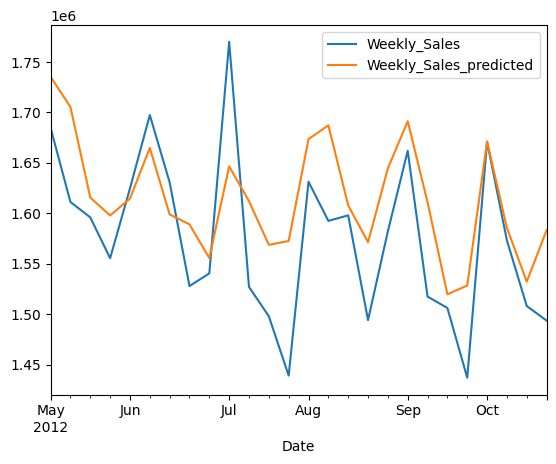

In [69]:
test_dataframe.query('Store==1').groupby('Date')[['Weekly_Sales', 'Weekly_Sales_predicted']].sum().plot()